# Training the models without K-Fold validation
This notebook aims to show the variability of the results without the K-Fold cross validation.
# Table of contents

1. [PCA](#pca)    
2. [Training and test](#training)    
2. [Validation](#validation)    
    1. [Confusion matrices](#confusion)    
    2. [ROC](#roc_val)    
    3. [Error metrics](#error)    
    4. [Spearman correlation](#spearman)    
    5. [Distribution of the data](#distribution)     

<a id='training'></a>
## Training and test

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('../features.lst', 'r') as file:
    features = file.read().splitlines()

In [3]:
# Read the data
training = pd.read_csv('../training_set.csv.gz', compression='gzip')
training[['CID','activity'] + features].head()

,CID,activity,GATS3m,GATS1m,AATS4i,GATS1pe,GATS4m,GATS3se,ATSC2m
0,JAG-UCB-4709a583-1,0,0.970061,0.537791,163.606396,0.665118,0.953853,0.957548,-7.853283
1,LON-WEI-b8d98729-9,0,0.962716,0.501345,156.473669,0.640952,0.764865,1.127119,-88.020465
2,MAT-POS-916a2c5a-2,1,0.930692,0.736034,156.298629,0.733243,1.085959,1.053636,-26.534927
3,ERI-BAS-37e2bb46-1,0,0.981993,0.723451,164.587065,0.742251,1.259074,0.993863,6.320989
4,LON-WEI-adc59df6-1,0,1.051077,0.833837,161.930498,0.668320,0.956446,0.942484,396.856136


In [4]:
def get_model_by_name(model_name):
    if model_name == 'RandomForestClassifier':
        from sklearn.ensemble import RandomForestClassifier
        return RandomForestClassifier(n_estimators=500, max_depth=6, random_state=13)
    elif model_name == 'KNeighborsClassifier':
        from sklearn.neighbors import KNeighborsClassifier
        return KNeighborsClassifier(n_neighbors=13)
    elif model_name == 'XGBClassifier':
        from xgboost import XGBClassifier
        return XGBClassifier(objective='binary:logistic', n_estimators=200, 
            max_depth=5, eta=0.01, random_state=13)
    elif model_name == 'LogisticRegression':
        from sklearn.linear_model import LogisticRegression
        return LogisticRegression(solver='liblinear', random_state=13)
    elif model_name == 'LinearSVC':
        from sklearn.svm import LinearSVC
        from sklearn.calibration import CalibratedClassifierCV
        # CalibratedClassifierCV applies probability transformation 
        # on top of the SVC outputs, so we can plot its ROC curve
        # https://stackoverflow.com/a/39712590/13131079
        return CalibratedClassifierCV(base_estimator=LinearSVC(dual=False, random_state=13))
    
    
def train_test_scores(X_train, X_test, y_train, y_test, pipe):
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import f1_score
    from imblearn.metrics import geometric_mean_score
    
    scores = []
    
    y_pred = pipe.predict(X_test)
    scores.append(f1_score(y_test, y_pred))              # test_f1
    scores.append(geometric_mean_score(y_test, y_pred))  # test_geometric_mean
    
    y_proba = pipe.predict_proba(X_test)[:,1]
    scores.append(roc_auc_score(y_test, y_proba))        # test_roc_auc
    
    y_pred = pipe.predict(X_train)
    scores.append(f1_score(y_train, y_pred))             # train_f1
    scores.append(geometric_mean_score(y_train, y_pred)) # train_geometric_mean
    
    y_proba = pipe.predict_proba(X_train)[:,1]
    scores.append(roc_auc_score(y_train, y_proba))       # train_roc_auc
    
    return scores


def feature_transformer(X):
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import OneHotEncoder

    return ColumnTransformer(transformers=[
        ('continuous', StandardScaler(), X.select_dtypes(include=float).columns.tolist()), 
        ('discrete', OneHotEncoder(handle_unknown='ignore'), X.select_dtypes(include=int).columns.tolist())
    ])

In [5]:
def plot_train_test_roc(axis, y_test, y_proba_test, y_train, y_proba_train, model_name):
    # Test ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba_test)
    axis[0].plot(fpr, tpr, label=model_name)

    # Training ROC
    fpr, tpr, _ = roc_curve(y_train, y_proba_train)
    axis[1].plot(fpr, tpr, label=model_name)

def pipeline(X, y, clf, transformer, axis, random_state):
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import make_pipeline
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    pipe = make_pipeline(SMOTE(random_state=42), transformer, clf)
        
    # Fit Pipeline
    pipe.fit(X_train, y_train)
    
    # Test and training scores
    scores = train_test_scores(X_train, X_test, y_train, y_test, pipe)
    
    y_proba_test = pipe.predict_proba(X_test)[:,1]
    y_proba_train = pipe.predict_proba(X_train)[:,1]
    
    # Plot ROC curve
    plot_train_test_roc(axis,  y_test, y_proba_test, y_train, y_proba_train, model_name)
    
    return scores

In [6]:
# ML classfifiers
classifiers = ['LogisticRegression','RandomForestClassifier','KNeighborsClassifier','LinearSVC','XGBClassifier']

y = training['activity']
X = training[features]

transformer = feature_transformer(X)

<a id='roc'></a>
## ROC

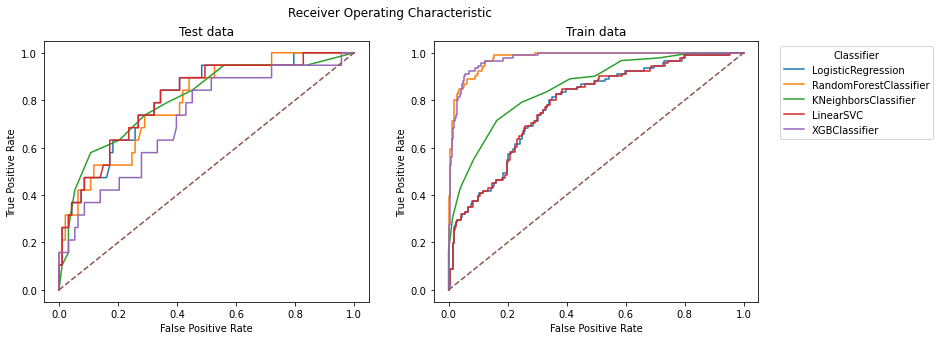

,test_f1,test_geometric_mean,test_roc_auc,train_f1,train_geometric_mean,train_roc_auc,clf,test_mean,train_mean
0,0.470588,0.704099,0.806735,0.492188,0.702418,0.779848,LogisticRegression,0.660474,0.658151
1,0.454545,0.664399,0.789757,0.781395,0.905024,0.976970,RandomForestClassifier,0.636234,0.887796
2,0.466667,0.723132,0.800792,0.533333,0.746700,0.854125,KNeighborsClassifier,0.663530,0.711386
3,0.470588,0.704099,0.807301,0.496124,0.706570,0.779848,LinearSVC,0.660663,0.660848
4,0.380952,0.594257,0.719015,0.819512,0.919277,0.975546,XGBClassifier,0.564741,0.904778


In [7]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fig, ax = plt.subplots(ncols=2, figsize=(12.8, 4.8))

scores = []
for model_name in classifiers:
    clf = get_model_by_name(model_name)
    model_scores = pipeline(X, y, clf, transformer, axis=ax, random_state=5)
    model_scores.append(model_name)
    scores.append(model_scores)

test_metrics = ['test_f1', 'test_geometric_mean', 'test_roc_auc']
train_metrics = ['train_f1', 'train_geometric_mean', 'train_roc_auc']
columns = test_metrics + train_metrics + ['clf']

scores = pd.DataFrame(scores, columns=columns)
scores['test_mean'] = scores[test_metrics].mean(axis=1)
scores['train_mean'] = scores[train_metrics].mean(axis=1)

# Labels and legend
ax[0].set(title='Test data', xlabel='False Positive Rate', ylabel='True Positive Rate')
ax[0].plot([0,1], [0,1], linestyle='--')
ax[1].set(title='Train data', xlabel='False Positive Rate', ylabel='True Positive Rate')
ax[1].plot([0,1], [0,1], linestyle='--')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, title='Classifier', bbox_to_anchor=(1.05, 1))
plt.suptitle('Receiver Operating Characteristic')
plt.show()

scores

### Testing with another random state

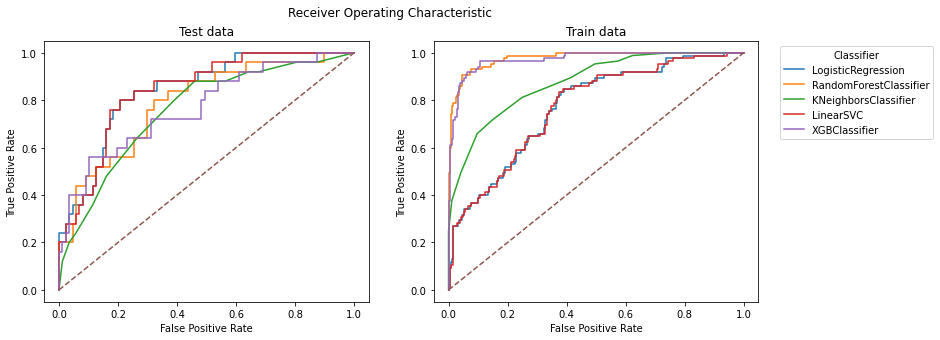

,test_f1,test_geometric_mean,test_roc_auc,train_f1,train_geometric_mean,train_roc_auc,clf,test_mean,train_mean
0,0.612903,0.776375,0.841839,0.454545,0.681347,0.770213,LogisticRegression,0.743706,0.635369
1,0.500000,0.671249,0.788046,0.790000,0.914728,0.977188,RandomForestClassifier,0.653098,0.893972
2,0.506329,0.698109,0.757011,0.517730,0.750883,0.876291,KNeighborsClassifier,0.653817,0.714968
3,0.612903,0.776375,0.840920,0.458333,0.683972,0.770181,LinearSVC,0.743399,0.637496
4,0.508475,0.684811,0.768736,0.802030,0.918941,0.971582,XGBClassifier,0.654007,0.897518


In [8]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fig, ax = plt.subplots(ncols=2, figsize=(12.8, 4.8))

scores = []
for model_name in classifiers:
    clf = get_model_by_name(model_name)
    model_scores = pipeline(X, y, clf, transformer, axis=ax, random_state=26)
    model_scores.append(model_name)
    scores.append(model_scores)

test_metrics = ['test_f1', 'test_geometric_mean', 'test_roc_auc']
train_metrics = ['train_f1', 'train_geometric_mean', 'train_roc_auc']
columns = test_metrics + train_metrics + ['clf']

scores = pd.DataFrame(scores, columns=columns)
scores['test_mean'] = scores[test_metrics].mean(axis=1)
scores['train_mean'] = scores[train_metrics].mean(axis=1)

# Labels and legend
ax[0].set(title='Test data', xlabel='False Positive Rate', ylabel='True Positive Rate')
ax[0].plot([0,1], [0,1], linestyle='--')
ax[1].set(title='Train data', xlabel='False Positive Rate', ylabel='True Positive Rate')
ax[1].plot([0,1], [0,1], linestyle='--')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, title='Classifier', bbox_to_anchor=(1.05, 1))
plt.suptitle('Receiver Operating Characteristic')
plt.show()

scores

### And another one

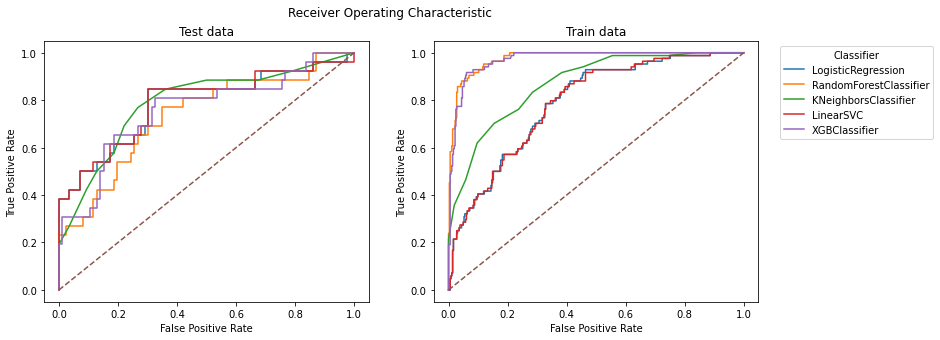

,test_f1,test_geometric_mean,test_roc_auc,train_f1,train_geometric_mean,train_roc_auc,clf,test_mean,train_mean
0,0.516129,0.687220,0.784436,0.462185,0.689708,0.788131,LogisticRegression,0.662595,0.646675
1,0.464286,0.633374,0.733900,0.776119,0.910237,0.976371,RandomForestClassifier,0.610520,0.887576
2,0.579710,0.750671,0.788238,0.544747,0.772156,0.870363,KNeighborsClassifier,0.706206,0.729089
3,0.524590,0.692407,0.785778,0.460251,0.688396,0.787901,LinearSVC,0.667592,0.645516
4,0.571429,0.717778,0.757603,0.795918,0.917255,0.972425,XGBClassifier,0.682270,0.895200


In [9]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fig, ax = plt.subplots(ncols=2, figsize=(12.8, 4.8))

scores = []
for model_name in classifiers:
    clf = get_model_by_name(model_name)
    model_scores = pipeline(X, y, clf, transformer, axis=ax, random_state=68)
    model_scores.append(model_name)
    scores.append(model_scores)

test_metrics = ['test_f1', 'test_geometric_mean', 'test_roc_auc']
train_metrics = ['train_f1', 'train_geometric_mean', 'train_roc_auc']
columns = test_metrics + train_metrics + ['clf']

scores = pd.DataFrame(scores, columns=columns)
scores['test_mean'] = scores[test_metrics].mean(axis=1)
scores['train_mean'] = scores[train_metrics].mean(axis=1)

# Labels and legend
ax[0].set(title='Test data', xlabel='False Positive Rate', ylabel='True Positive Rate')
ax[0].plot([0,1], [0,1], linestyle='--')
ax[1].set(title='Train data', xlabel='False Positive Rate', ylabel='True Positive Rate')
ax[1].plot([0,1], [0,1], linestyle='--')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, title='Classifier', bbox_to_anchor=(1.05, 1))
plt.suptitle('Receiver Operating Characteristic')
plt.show()

scores